# The relationship between spatial coupling and incidence correlation in a 2-patch model
Ref: Keeling & Rohani, _Estimating spatial coupling in epidemiological systems: a mechanistic approach_, Ecol. Letters (2002) 5:20-29


In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Random_Agents

from laser_generic.utils import set_initial_susceptibility_in_patch
from laser_generic.utils import seed_infections_in_patch

%load_ext line_profiler

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [2]:
nticks = 36500
scenario = pd.DataFrame(data=[["patch1", 1e6],
                        ["patch2", 1e6]], 
                        columns=["name", "population"])
parameters = PropertySet({"seed": 4, 
                        "nticks": nticks,
                        "verbose": True, 
                        "beta": 0.4,
                        "inf_mean": 12,
                        "cbr": 45, 
                        "importation_period": 180, 
                        "importation_count": 3, 
                        "importation_start": 500,
                        })

mu = ((1+parameters.cbr/1000)**(1/365)-1) 
R0 = parameters.beta/(mu + 1/parameters.inf_mean)
nsims = 100
i = 0
outputs = np.zeros((nsims, parameters.nticks, scenario.shape[0]))
for connection in np.logspace(-4, -1, nsims):
    model = Model(scenario, parameters)
    model.components = [Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]   

    #Start them slightly asynchronously - different initial susceptibilities, infection only in 1 patch
    #Want to see how connectivity drives correlation over time.
    model.patches.network = np.array([[0, connection], [connection, 0]])
    set_initial_susceptibility_in_patch(model, 1, 1/R0+.02*np.random.normal())
    set_initial_susceptibility_in_patch(model, 0, 1/R0+.02*np.random.normal())
    seed_infections_in_patch(model, ipatch=0, ninfections=3)


    model.run()
    outputs[i, :, :] = model.patches.cases
    i+=1



2024-12-21 22:07:44.266061: Creating the generic model…
Initializing the generic model with 2 patches…
2024-12-21 22:07:44.320624: Running the generic model for 36500 ticks…


  4%|▍         | 1527/36500 [00:13<04:59, 116.81it/s]


KeyboardInterrupt: 

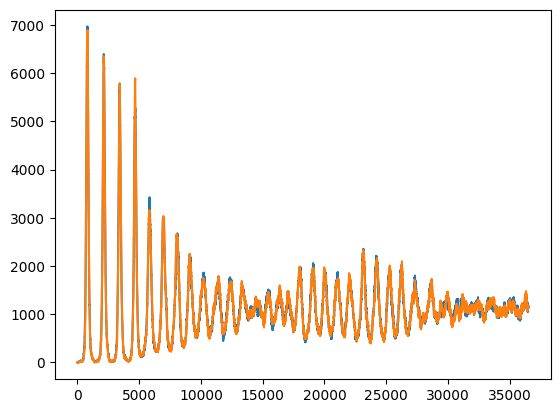

In [20]:
plt.plot(outputs[9, :, :])



In [ ]:
%%timeit
condition = np.nonzero(model.population.susceptibility[0 : model.population.count])


5.19 ms ± 112 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
np.random.choice(np.squeeze(np.where(model.population.nodeid==1)), 5000, replace=False)

array([1963635, 1987010, 1963568, ..., 1458410, 1172392, 1462135])

In [2]:
model.population.nodeid.shape

NameError: name 'model' is not defined

In [ ]:
def add_at(A, indices, B):
    sorted_indices = np.argsort(indices)
    uniques, run_lengths = np.unique(indices[sorted_indices], return_counts=True)
    for i, length, end in zip(uniques, run_lengths, run_lengths.cumsum()):
        A[i] += B[sorted_indices[end-length:end]].sum(axis=0)    
patches = model.patches
contagion = patches.cases[0, :]
population = model.population
condition = population.itimer[0 : population.count] > 0  # just look at the active agent indices
nodeids = population.nodeid[0 : population.count]
add_at(contagion, nodeids[condition], np.ones_like(nodeids[condition]))


In [ ]:
indices = nodeids[condition]

In [ ]:
sorted_indices = np.argsort(indices)

array([0, 1, 2])

In [9]:
x = np.ones((100, 2))
y = np.random.randint(0, 2, (100, 2))
np.count_nonzero(x-y, axis=1)

array([50, 45])

In [16]:
uniques

array([0], dtype=uint16)

In [17]:
run_lengths

array([3])

In [20]:
i = uniques[0]
length = run_lengths[0]
end = run_lengths.cumsum()[0]

In [21]:
sorted_indices[end-length:end]

array([0, 1, 2])